# Regression 

In [86]:
import jax.numpy as np
import jax
from matplotlib import pyplot as plt
from jax.lib import xla_bridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import ADAMLL as ada
from ADAMLL.activations import relu, sigmoid, eye
print("jax backend {}".format(xla_bridge.get_backend().platform))

jax backend gpu


## Data

In [134]:
n = 32  # Number of rows
m = 32  # Number of columns
perlin_noise_map = ada.generate_perlin_noise(n, m, seed=8, scale=0.05) + jax.random.normal(jax.random.PRNGKey(2024), (n, m)) * 0.08

def simplerFunction(x):
    return 0.2*x + 0.8*x**2 + 2*x**3


x shape: (1024, 2)
t shape: (1024, 1)


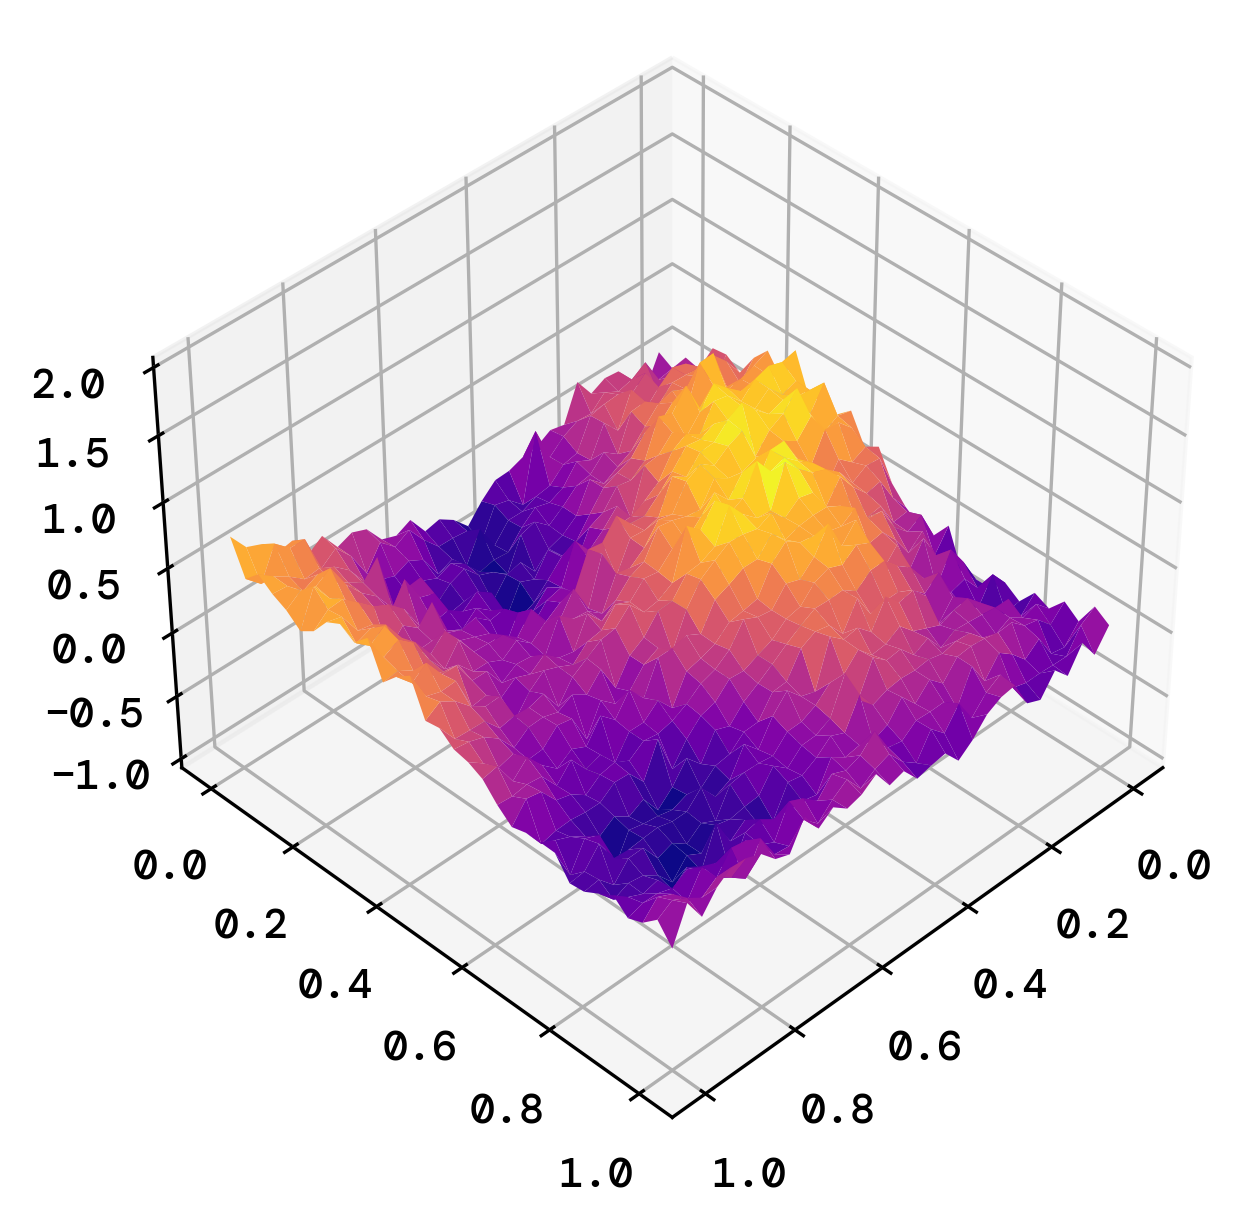

In [135]:
x = np.linspace(0, 1, 32)
y = np.linspace(0, 1, 32)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, perlin_noise_map, cmap='plasma',
                       linewidth=0, antialiased=True)
ax.set_zlim(-1.01, 2.01)
ax.view_init(40, 45)


x = np.vstack([X.ravel(), Y.ravel()]).T
y = perlin_noise_map.reshape(-1, 1)

print("x shape: {}".format(x.shape))
print("t shape: {}".format(y.shape))

## Preprocessing

In [136]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1234)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

# Analysis

In [137]:
etas = [ 0.0001, 0.001, 0.01  ]
epochs =200
tol = 0.001
gammas = [0.0, 0.1, 0.5, 0.9]
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0]
epsilon = 1e-8
decay = 0.9
beta1 = 0.9
beta2 = 0.999

poly = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)



def runGD():
    scoresSgd = np.zeros((len(etas), len(gammas),epochs))
    for i, eta in enumerate(etas):
        for j, gamma in enumerate(gammas):
            sgd     =  ada.NN.Model([[1,eye]], eta=eta, epochs=epochs, tol=tol, gamma=gamma , alpha=0, optimizer="sgd", loss=ada.MSE, metric=ada.MSE) 
            loss, _ = sgd.fit(X_train_poly, y_train, X_test_poly, y_test)
            scoresSgd = scoresSgd.at[i,j,:].set(loss)
            print(ada.progress_bar(i*len(gammas) + j, len(etas)*len(gammas)))
    return scoresSgd



In [138]:
scoresSgd = runGD()

Training stopped after 199 epochs                                     Progress: [>                   ] 0%
Training stopped after 199 epochs                                     Progress: [>                   ] 8%
Training stopped after 199 epochs                                     Progress: [-->                 ] 16%
Training stopped after 199 epochs                                     Progress: [---->               ] 25%
Training stopped after 199 epochs                                     Progress: [----->              ] 33%
Training stopped after 199 epochs                                     Progress: [------->            ] 41%
Training stopped after 199 epochs                                     Progress: [--------->          ] 50%
Training stopped after 199 epochs                                     Progress: [---------->         ] 58%
Training stopped after 199 epochs                                     Progress: [------------>       ] 66%
Training stopped after 199 epochs      

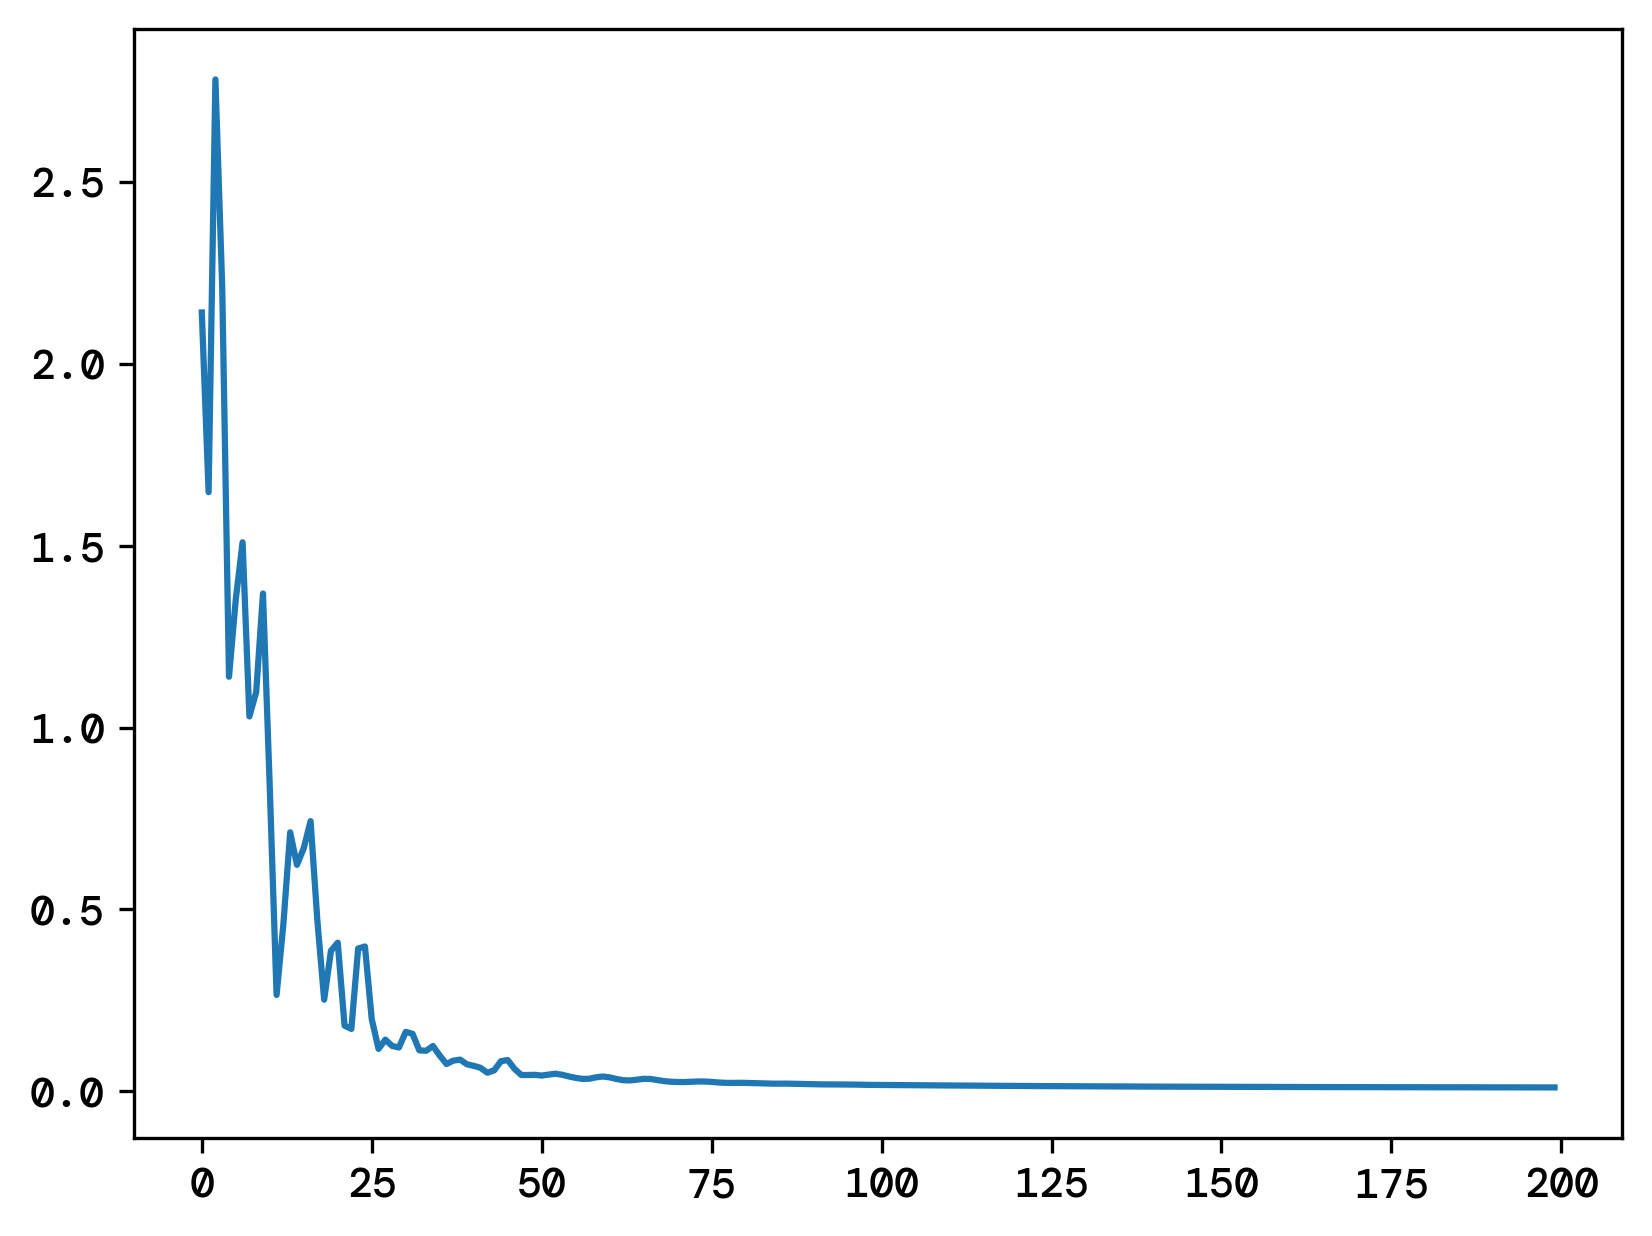

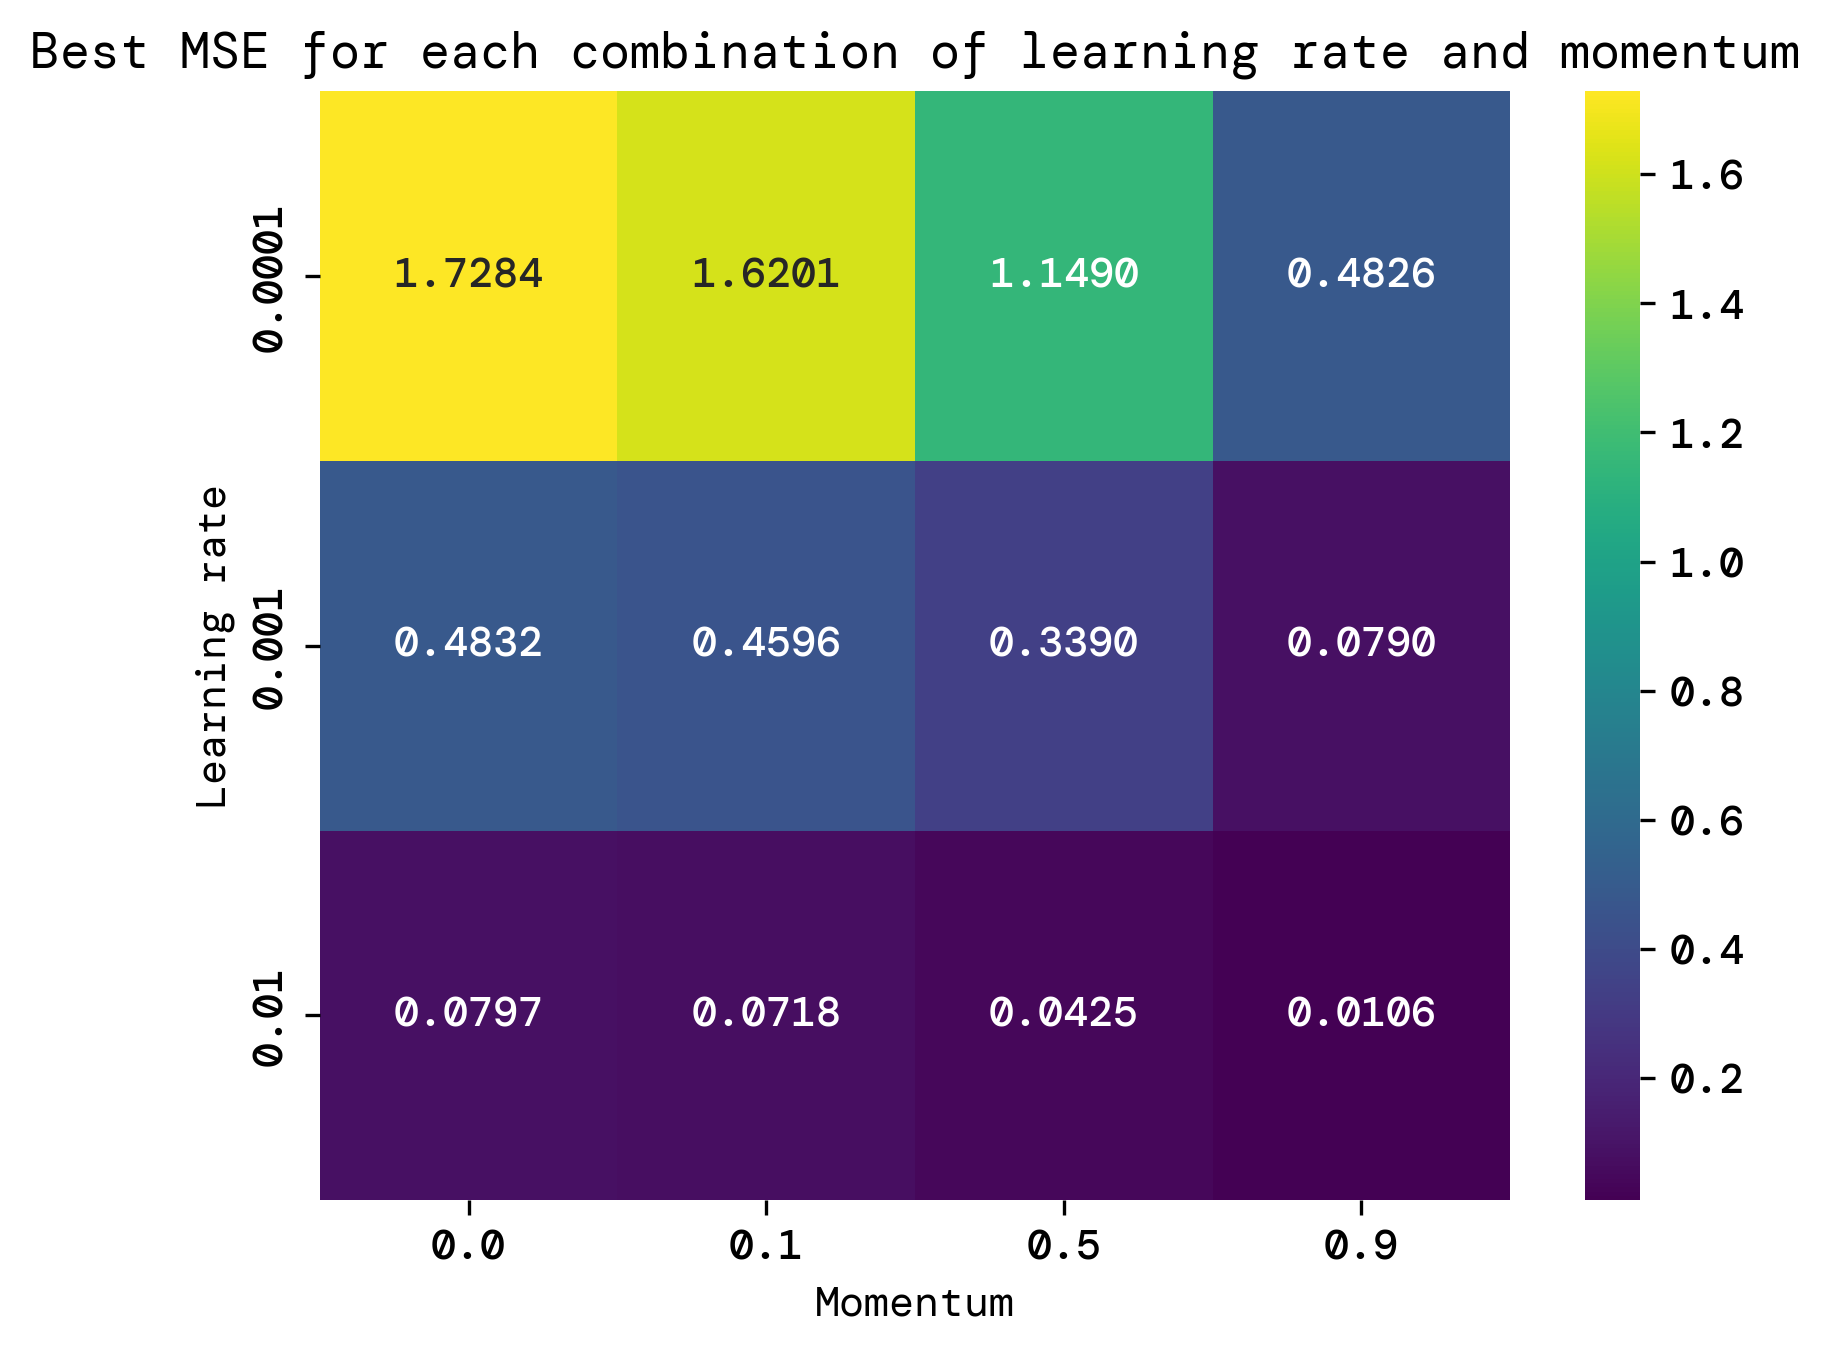

In [139]:
import seaborn as sns


fig, ax = plt.subplots(1, 1)
ax.plot(scoresSgd[3,3,:])


plt.figure()
ax = sns.heatmap(np.min(scoresSgd,axis=2), annot=True, fmt=".4f", cmap="viridis")
ax.set_title("Best MSE for each combination of learning rate and momentum")
ax.set_xlabel("Momentum")
ax.set_xticklabels(gammas)
ax.set_ylabel("Learning rate")
ax.set_yticklabels(etas)
plt.show()



In this case havving momentum seems to be beneficial. We maxes out our testing range and found that 0.9 was the best value for momentum.

X_train_poly shape: (819, 14)
Training stopped after 199 epochs                                     

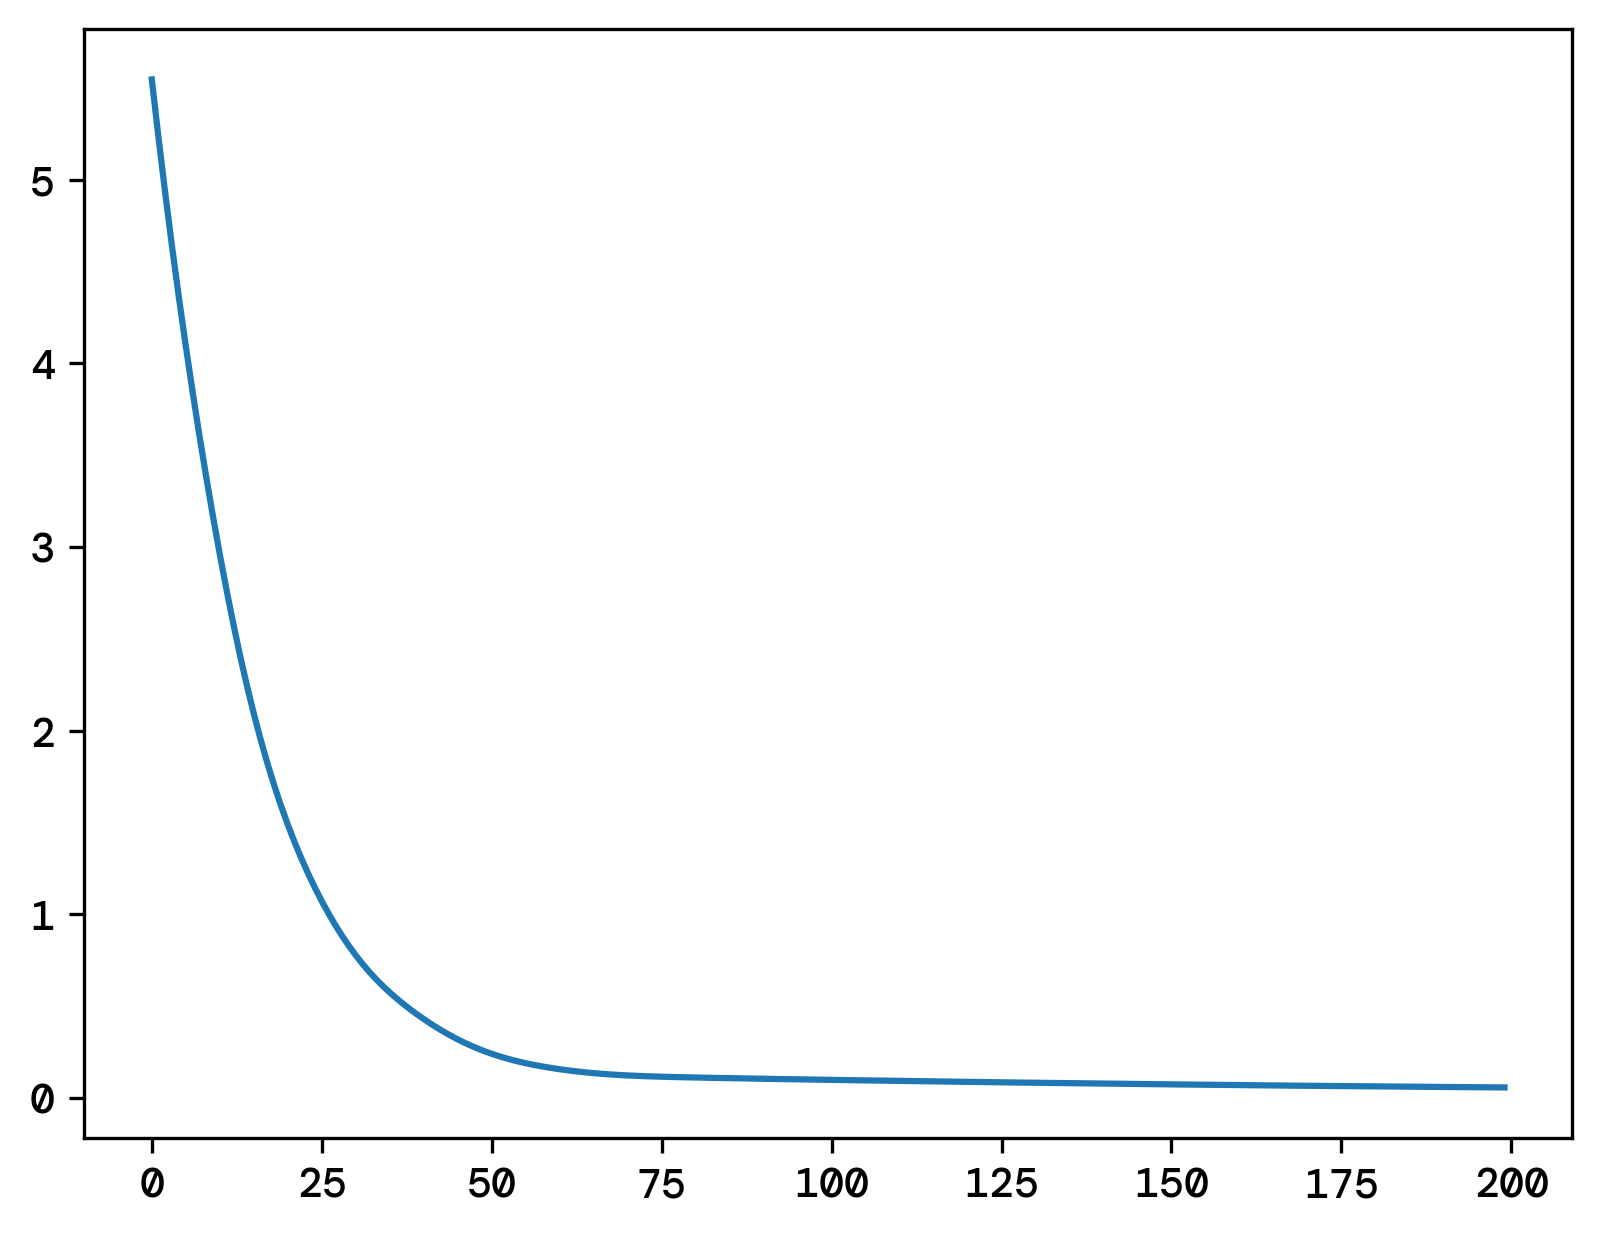

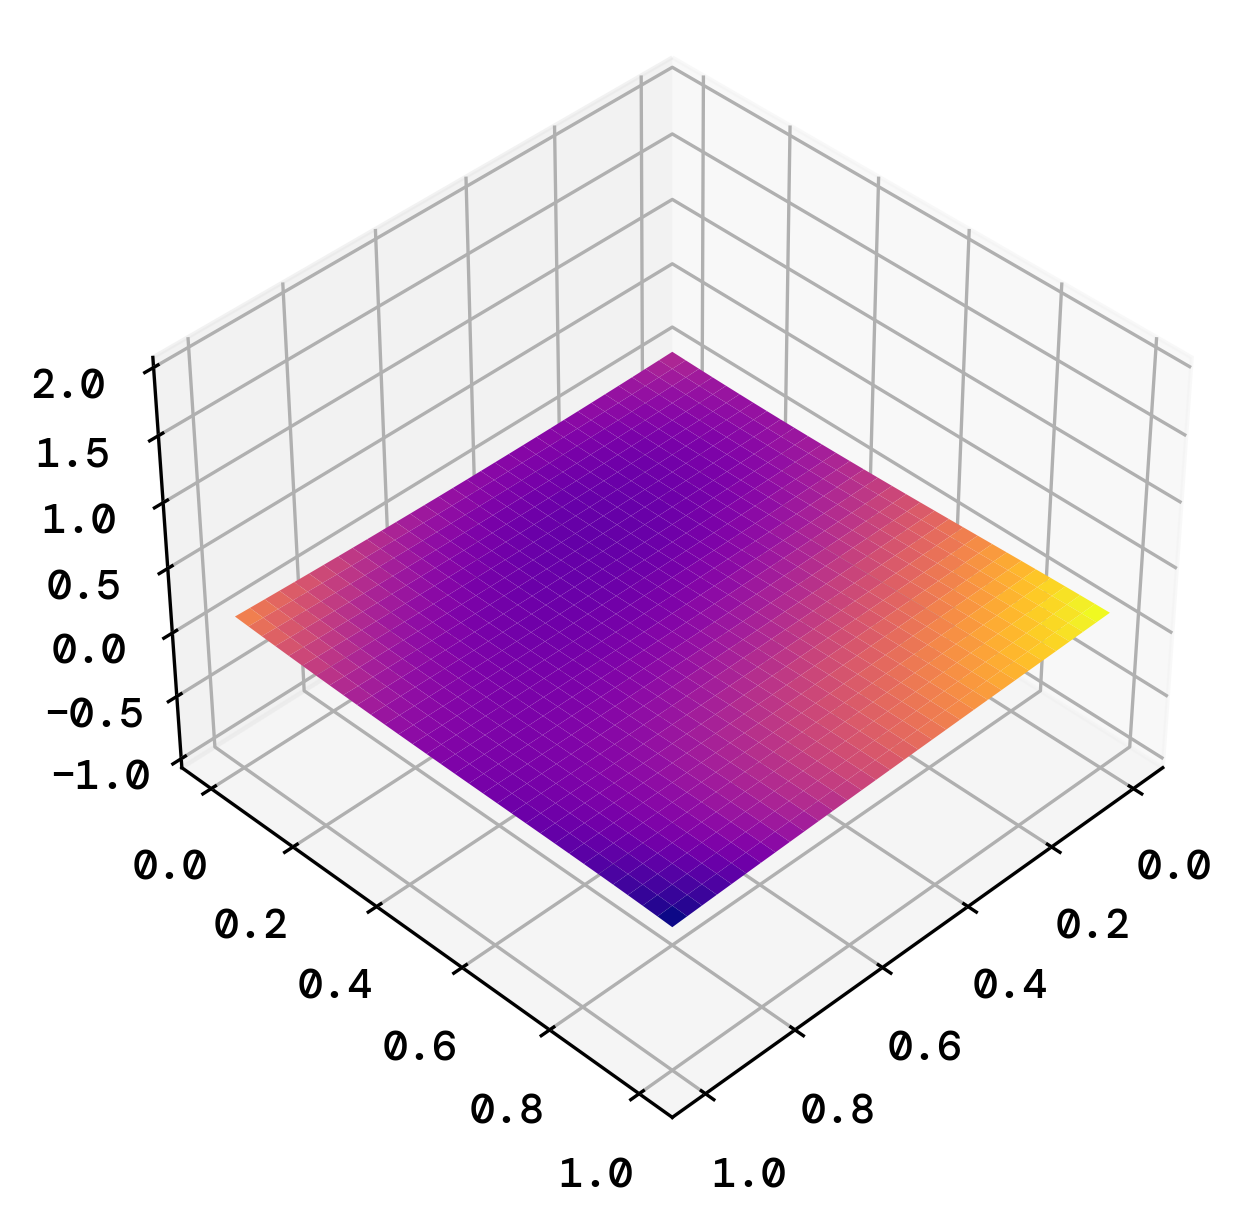

In [159]:
# plot predictions
poly = PolynomialFeatures(degree=4, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
print("X_train_poly shape: {}".format(X_train_poly.shape))

      
model = ada.NN.Model([[1,eye]], eta=0.01, epochs=200, tol=tol, alpha=0, gamma=0.5, optimizer="adam", loss=ada.MSE, metric=ada.MSE)

loss, params = model.fit(X_train_poly, y_train, X_test_poly, y_test)

y_pred = model.predict(poly.transform(x))


fig, ax = plt.subplots(1, 1)
ax.plot(loss)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, y_pred.reshape(32,32), cmap='plasma',
                       linewidth=0, antialiased=True)
ax.set_zlim(-1.01, 2.01)
ax.view_init(40, 45)





# Automatic differentiation

In [157]:
auto = ada.NN.Model([[1,eye]], eta=0.1, epochs=100, tol=tol, gamma=0.9 , alpha=0, epochs=50)
manual = ada.NN.Model([[1,eye]], eta=0.1, epochs=100, tol=tol, gamma=0.9, backwards=ada.NN.backwards_no_hidden, alpha=0, epochs=50)

lossAuto, params_auto = auto.fit(X_train, y_train, X_test, y_test)
lossManual, params = manual.fit(X_train, y_train, X_test, y_test)

plt.figure()
plt.plot(lossAuto,label="auto")
plt.plot(lossManual,"--", label="manual")
plt.legend()
print("auto vs manual")
print("auto",params_auto[0])
print("manual",params[0])

SyntaxError: keyword argument repeated: epochs (3445425602.py, line 1)

As we can see the analytical and automatic differentiation gives the same results.

## Batch gradient descent / stochastic gradient descent

In [ ]:
def runSTG(batch_size=5):
    scoresAdagrad = np.zeros((len(etas), epochs))
    scoresRmsprop = np.zeros((len(etas), epochs))
    scoresAdam = np.zeros((len(etas), epochs))
    for i, eta in enumerate(etas):
        rmsprop = NN(eta=eta, epochs=epochs, tol=tol, epsilon=epsilon, gamma=decay, optimizer='rmsprop', backwards=gradients)
        adam = NN(eta=eta, epochs=epochs, tol=tol, beta1=beta1, beta2=beta2, epsilon=epsilon,
                  optimizer='adam', backwards=gradients)
        rms,_ = rmsprop.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
        adam_loss, _ =adam.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
        scoresRmsprop = scoresRmsprop.at[i,:].set(rms)
        scoresAdam =  scoresAdam.at[i,:].set(adam_loss)
        adagrad = NN(eta=eta, epochs=epochs, tol=tol, backwards=gradients, alpha=0, optimizer='adagrad')
        ada, _ =adagrad.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
        scoresAdagrad = scoresAdagrad.at[i,:].set(ada)
        print(progress_bar(i, len(etas)))
            


    return scoresAdagrad, scoresRmsprop, scoresAdam 

In [ ]:
ada, rms, adam = runSTG(batch_size=20)

Training stopped after 399 epochs                           Progress: [>                   ] 0%
Training stopped after 399 epochs                           Progress: [---->               ] 25%
Training stopped after 399 epochs                           Progress: [--------->          ] 50%
Training stopped after 399 epochs                           Progress: [-------------->     ] 75%


best eta for adagrad, rmsprop, adam in that order


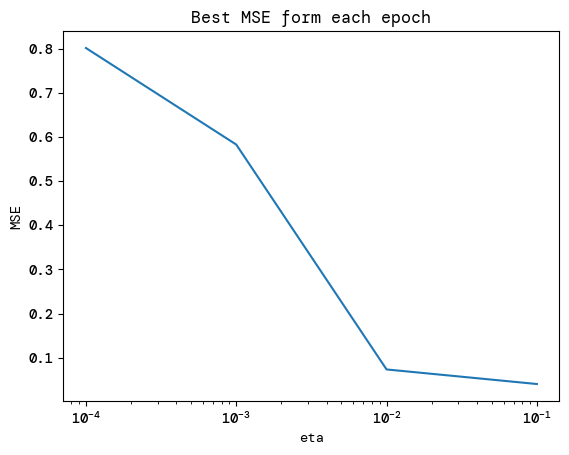

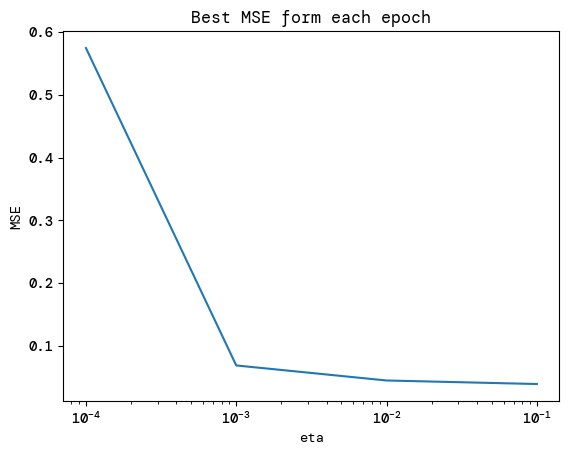

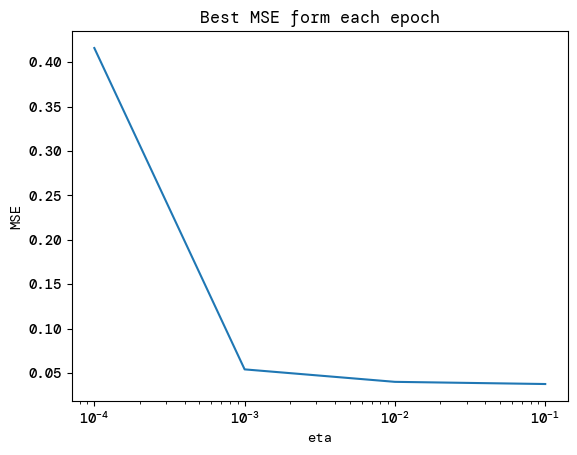

In [ ]:

print("best eta for adagrad, rmsprop, adam in that order")

scores_rest = np.array((ada,rms,adam))
for scores in scores_rest:
    scores = np.min(scores,axis=1)
    fig, ax = plt.subplots(1, 1)
    ax.plot(etas,scores)
    ax.set_title("Best MSE form each epoch")
    ax.set_xlabel("eta")
    ax.set_xticks(etas)
    ax.set_xscale('log')
    ax.set_ylabel("MSE")
    plt.show()



In this analysis every model seemed to have converged with the same final MSE, give or take. However 
we see that some models allows us to use a wider range of learning rates. This is especially true for the models with momentum. These new optimizers and auto differentiation is a new tool in our toolbox that we can use to optimize our models.